In [ ]:
%pip install devtools --quiet

# **Medical Assistant**

DEFINICAO DE ROTA -- FAZER ISSO NO JAVA / TYPE SCRIPT

Assistente medico genAI tem que decidir e auxiliar para dois scenarios: Emergencial e Diagnostico Diferencial.

Dado o estado de um paciente, ex: dor no peito, calafrio, confusao mental. O assistente tem que decidir se deveria, rotear para a sugestao (state) emergencial ou diagnostico diferencial. 

O Assiste deve saber quando a descrição do usuario é sobre algo que pode estar descrevendo uma doença/fatalidade que pode ocorrer naquele momento, ou uma doença/condicao que precisa de trato imediate ou se o usuario este perguntando,fazendo uma busca sobre um diagnostico diferencial.

Essa applicação tera 3 prompts:
      1. Prompt Rotear se deveramos ir pro state emergencial, pro state diagnostico diferencial, ou usar o tool AskHuman. 
      2. Prompt quando estiver no state emergencial.
      3. Prompt pra quando no state diagnostico differencial.

Explicação dos States
1. emergencial
      - Dado o estado do paciente, o assistente pode, por exemplo, 
      sugerir um pronto atendimento. ex: dor no peito, calafrio, confusao mental. Pode ser infarto.entao sugerir a internacao ou procedimento etc.. 
      - Quando neste state (emergencial) a meta é sugerir algo para ser tomado com um certa urgencia, por isso o nome do state é emergencial.

2. diagnostico diferencial
      - baseado numa descricao (text) do estado do paciente, investigar a causa.
      - Esse sate eh mais pra buscar causas

Explicação do tool AskHuman:
- Se existe duvidas sobre a descrição do paciente, o LLM deve perguntar mais pro usuario para entender sua descrição e decidir pra qual state ir (emergencial ou diagnostico diferencial)


ROUTER_PROMPT:
- se o input do usuario nao eh claro, perguntar pro usuario se é emergencia ou diagnostico differencial.
- Caso de ambiguidade sobre quais decisoes tomar: 
      - algo mais emergencial 
      - busca investigacao 


- Human in the loop para:
      - clarificacao ou confirmacao (confirmacao so pra fins de aprender)
      - confirmacao seria mais pra processos de arvore de decisao

TESTER API do MEMED.
- supondo que .... gerar a receita.
- comeca a testar com o postman


BULARIO
- se puxar 20 remedios, como ele vai mostrar a informacao? uma tabela? 
- batch embedding

In [7]:
import os
from typing import Literal, Optional
from datetime import datetime
from devtools import pprint

from dotenv import load_dotenv
from IPython.display import Image, display
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI, OpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver

load_dotenv()  # Load environment variables from the .env file
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['LANGSMITH_TRACING'] = os.getenv('LANGSMITH_TRACING')
os.environ['LANGSMITH_ENDPOINT'] = os.getenv('LANGSMITH_ENDPOINT')
os.environ['LANGSMITH_API_KEY'] = os.getenv('LANGSMITH_API_KEY')
os.environ['LANGSMITH_PROJECT'] = os.getenv('LANGSMITH_PROJECT')

In [8]:
VALID_DECISION_OPTIONS = {"emergencial", "diagnostico_diferencial", "ask_human"}

class RouterResponse(BaseModel):
    decision: Literal["emergencial", "diagnostico_diferencial", "ask_human", ""] = Field(
        description="Decisão sobre qual caminho seguir com base na descrição do paciente"
    )
    case_synthesis: Optional[str] = Field(
        default=None,
        description="Síntese técnica do caso a ser analisado"
    )
    question_to_human: Optional[str] = Field(
        default=None,
        description="Pergunta específica para o usuário quando há necessidade de esclarecimento"
    )
    decision_reason: Optional[str] = Field(
        default=None,
        description="Explicação pela qual a decisão emergencial, diagnostico_diferencial, ask_human foi feita."
    )

# State
class State(MessagesState):
      initial_human_input: Optional[str]
      decision: Literal["emergencial", "diagnostico_diferencial", "ask_human", ""] 
      case_synthesis: Optional[str]
      question_to_human: Optional[str] 
      final_answer: Optional[str]
      
# Model
model = ChatOpenAI(model = "gpt-4o-mini")
model = model.with_structured_output(RouterResponse)

Emergencial: 
- Estou com dor no peito que irradia para o braço esquerdo e falta de ar.
- Meu filho de 4 anos está com febre alta de 40°C que não baixa com remédios e está muito letárgico.

Diagnostico diferencial:
- Tenho dor de cabeça frequente nos últimos 3 meses, principalmente de tarde.
- Minha pele está ficando amarelada e sinto cansaço constante.

In [9]:
ROUTER_PROMPT = """Você é um LLM Router em um sistema médico multiagente. Sua função é avaliar se as informações fornecidas pelo usuário (médicos auxiliando pacientes) são SUFICIENTES para tomar uma decisão segura ou se é necessário solicitar mais dados.
CONTEXTO DO SISTEMA:
Este sistema possui 3 componentes:
1. VOCÊ (LLM Router): Responsável por analisar o input do usuário e, com base nas informações coletadas (possivelmente ao longo de várias interações), decidir se o caso precisa ser encaminhado para o Agente Emergencial ou para o Agente de Diagnóstico Diferencial.
   **O parâmetro "case_synthesis" deve ser atualizado a cada interação, agregando todas as informações coletadas e formando uma síntese técnica clara e completa do caso.**
2. Agente Emergencial: Especializado na orientação de casos que demandam atendimento imediato.
3. Agente de Diagnóstico Diferencial: Especializado na investigação de condições clínicas que não indiquem urgência imediata.

CRITÉRIOS DE INSUFICIÊNCIA DE INFORMAÇÕES:
Considere INSUFICIENTES os inputs que:
- Sejam menção isolada de um sintoma (ex.: "dor no peito", "febre", "dor de cabeça");
- Sejam apenas nomes de doenças sem qualquer contexto (ex.: "tuberculose", "diabetes");
- Sejam descrições vagas (ex.: "não me sinto bem", "estou doente");
- Não contenham detalhes como duração, intensidade ou outros dados clínicos relevantes.  
Nesses casos, você DEVE escolher "ask_human" e fazer perguntas específicas para obter mais informações.

SUA TAREFA ESPECÍFICA:
1. Avaliar se o input do usuário contém dados clínicos suficientes para decidir se o caso é emergencial ou se precisa de uma investigação diagnóstica.
2. Se as informações forem insuficientes, escolher "ask_human" e solicitar detalhes adicionais.
3. Se as informações forem suficientes:
   - Decidir entre "emergencial", se os dados indicarem uma situação de risco imediato (por exemplo, dor torácica com irradiação, dispneia e outros sinais de alerta);
   - Ou "diagnostico_diferencial", se os dados permitirem uma investigação diagnóstica sem indicar emergência.
4. **Caso haja múltiplas interações para esclarecer o problema:**  
   A cada nova interação com o usuário, você deve atualizar o parâmetro "case_synthesis" agregando as novas informações à síntese acumulada. O "case_synthsesis" deve refletir todas as informações obtidas até o momento. Ao final do processo, quando você decidir entre "emergencial" ou "diagnostico_diferencial", o campo "case_synthesis" deverá conter a síntese completa e atualizada de todo o caso, servindo como um briefing claro e preciso para o próximo agente.
   
   Essa síntese técnica deve:
   - Incluir dados relevantes fornecidos pelo usuário (sintomas, duração, intensidade, evolução, etc.);
   - Refletir de forma objetiva o entendimento acumulado do caso;
   - Servir como um briefing claro e preciso para o próximo agente (emergencial ou diagnóstico diferencial).

PARÂMETROS DA SUA RESPOSTA:
- "decision": Sua decisão final ("emergencial", "diagnostico_diferencial" ou "ask_human").
- "case_synthesis": Deve ser preenchido ao longo da interação com o usuário e quando a decisão não for "ask_human".  
  Para casos encaminhados, ele consiste em uma síntese técnica que combina todas as informações relevantes coletadas no caso, permitindo que o próximo agente entenda o contexto clínico e as razões que fundamentaram a decisão.
- "question_to_human": Pergunta(s) específica(s) para obter mais informações, a ser utilizado quando a decisão for "ask_human".
- "decision_reason": Justificativa para sua decisão, indique se as informações foram suficientes ou não e explicar quais dados faltaram, se for o caso.

EXEMPLOS CORRETOS:

INPUTS INSUFICIENTES:
Exemplo 1:  
Input: "Dor no peito"  
Resposta:
{
  "decision": "ask_human",
  "case_synthesis": "Dor no peito",
  "question_to_human": "Para avaliar melhor, por favor informe: há quanto tempo o paciente sente essa dor? Ela irradia para braço ou mandíbula? Há outros sintomas, como falta de ar ou náuseas?",
  "decision_reason": "Informações insuficientes. 'Dor no peito' isolada não permite avaliar gravidade sem dados adicionais sobre duração, irradiação e sintomas associados."
}

Exemplo 2:  
Input: "Tuberculose"  
Resposta:
{
  "decision": "ask_human",
  "case_synthesis": "Tuberculose",
  "question_to_human": "O termo 'tuberculose' foi informado isoladamente. Por favor, forneça mais detalhes: quais sintomas o paciente apresenta, há quanto tempo, presença de tosse, febre ou perda de peso?",
  "decision_reason": "Input insuficiente. 'Tuberculose' sem contexto não permite determinar se o caso é uma suspeita, dúvida diagnóstica ou confirmação."
}

INPUTS SUFICIENTES:
Exemplo 3:  
Input: "Dor no peito intensa há 30 minutos que irradia para o braço esquerdo, com falta de ar e suor frio."  
Resposta:
{
  "decision": "emergencial",
  "case_synthesis": "Paciente com dor torácica intensa iniciada há 30 minutos, com irradiação para o braço esquerdo, associada à dispneia e diaforese, compatível com um quadro de síndrome coronariana aguda.",
  "question_to_human": "",
  "decision_reason": "As informações fornecidas são suficientes para indicar uma emergência devido ao conjunto de sinais clínicos presentes."
}

Exemplo 4 (com múltiplas interações):  
Durante a conversa, foram coletados os seguintes dados do paciente:
- Primeira interação: "Paciente com dor de cabeça."
   - parametro "case_synthesis": "Paciente com dor de cabeça."
- Segunda interação: "É uma dor frontal que vem há 3 meses."
   - parametro "case_synthesis": "Paciente com dor de cabeça frontal há 3 meses." 
- Terceira interação (após questionamento adicional): "Não há náuseas ou alterações visuais, mas a dor piora à tarde."
   - parametro "case_synthesis": "Síntese acumulada: Inicialmente relatada dor de cabeça inespecífica, evoluindo para uma dor frontal persistente há 3 meses, sem sinais de alarme (como náuseas ou alterações visuais) e com piora à tarde."
Resposta final:
{
  "decision": "diagnostico_diferencial",
  "case_synthesis": "Síntese acumulada: Inicialmente relatada dor de cabeça inespecífica, evoluindo para uma dor frontal persistente há 3 meses, sem sinais de alarme (como náuseas ou alterações visuais) e com piora à tarde.",
  "question_to_human": "",
  "decision_reason": "As informações acumuladas ao longo das interações são suficientes para orientar um diagnóstico diferencial, embora não indiquem risco imediato."
}

LEMBRE-SE: Caso haja qualquer dúvida sobre a suficiência das informações fornecidas pelo usuário, escolha a opção "ask_human". Utilize "ask_human" no máximo 3 vezes.

Agora, analise o caso apresentado pelo usuário:
"""
EMERGENCIAL_PROMPT = """Você é um especialista médico. Avalie o caso emergencial para: {input}

Objetivo:
Oferecer orientações urgentes e baseadas em evidências.

Instruções:
1. Avaliação: Identifique a condição emergencial provável.
2. Protocolo: Recomende a ativação imediata do SAMU (192), especifique a janela terapêutica e o nível do hospital necessário.
3. Intervenções: Sugira posicionamento, monitoramento de sinais vitais (e.g., FC, PA, O₂) e suporte pré-hospitalar.
4. Contraindicações: Aponte procedimentos e medicações a evitar.
5. Critérios de Gravidade: Destaque sinais que indiquem deterioração e necessidade de ação urgente.

Utilize terminologia médica precisa, baseando-se em protocolos atualizados (ACLS, ATLS, AHA) e adapte as instruções conforme o público (profissionais ou leigos).
"""

DIAGNOSTICO_DIFERENCIAL_PROMPT = """Você é um especialista médico. Avalie o diagnóstico diferencial para: {input}
Instruções:
1. SÍNTESE: Resuma os dados clínicos principais.
2. DIAGNÓSTICOS: Liste 3–5 causas (por ordem de probabilidade), detalhando mecanismo, relação com o caso e sinais de alerta.
3. INVESTIGAÇÃO: Sugira exames (laboratoriais/imagem) e avaliações especializadas.
4. RECOMENDAÇÕES: Indique orientações não medicamentosas e critérios para atendimento urgente.

Regras:
- Use linguagem técnica e clara.
- Não prescreva medicamentos.
- Baseie sua análise em evidências clínicas atualizadas.
"""

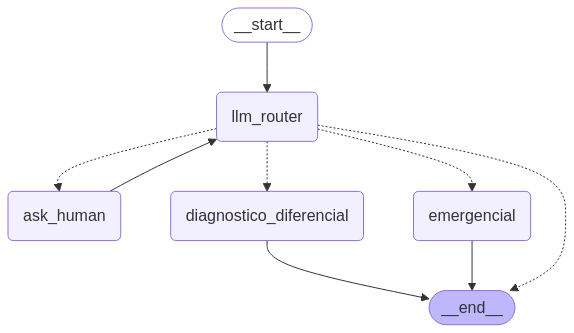

In [10]:
global INTERACTION_COUNT
INTERACTION_COUNT = 0
# NODES
# LLM router
def llm_router(state: State):
      if state["messages"] and state["messages"][-1].type == "human":
            human_input = state["messages"][-1].content
            print("\nHuman input: ", human_input)

            response = model.invoke(state["messages"])

            print("THIS IS THE ROUTER RESPONSE:")
            pprint(response)
            
            state["decision"] = response.decision
            state["question_to_human"] = response.question_to_human
            state["case_synthesis"] = response.case_synthesis
            print("Added response to state:")
            print("Decision:", state["decision"])
            print("Question to Human:", state["question_to_human"])
            print("Case Synthesis:", state["case_synthesis"])

            # Add the next question to human or case_synthesis to the chat history
            if response.question_to_human and response.decision == "ask_human":
                 state["messages"].append(AIMessage(content=response.question_to_human))
            else:
                 state["messages"].append(AIMessage(content=response.case_synthesis))

      else:
            raise ValueError("Expected a human message in state['messages'].")

      return state



# Emergencial
def emergencial(state: State):
      global INTERACTION_COUNT
      print('INSIDE EMERGENCIAL')
      if state["case_synthesis"]:
            input = state["case_synthesis"]
            print(f"Using case_synthesis: {input}")
      else:
            input = next((msg for msg in reversed(state["messages"]) if msg.type == "ai"), state["messages"][1:])
            print(f"Falling back on the last message from the LLM router: {input}")

      response = ChatOpenAI(model="gpt-4o-mini").invoke(EMERGENCIAL_PROMPT.format(input=input))
      state["final_answer"] = response.content
      # Add final answer to the chat history
      state["messages"].append(AIMessage(content=response.content))
      # Reset count
      INTERACTION_COUNT = 0 
      
      return state

# Diagnositico Diferencial
def diagnostico_diferencial(state: State):
      global INTERACTION_COUNT
      print("INSIDE DIAGNOSTICO DIFERENCIAL")
      if state["case_synthesis"]:
            input = state["case_synthesis"]
            print(f"Using case_synthesis: {input}")
      else:
            input = next((msg for msg in reversed(state["messages"]) if msg.type == "ai"), state["messages"][1:])
            print(f"Falling back on the last message from the LLM router: {input}")
      
      response = ChatOpenAI(model="gpt-4o-mini").invoke(DIAGNOSTICO_DIFERENCIAL_PROMPT.format(input=input))
      state["final_answer"] = response.content
      # Add final answer to the chat history
      state["messages"].append(AIMessage(content=response.content))

      # Reset count
      INTERACTION_COUNT = 0 
      
      return state

# Human Node
def ask_human(state: State):
      print(" INSIDE ask_human node")
      question = state["question_to_human"]

      if state["messages"]:
          if not(state["messages"][-1].type == "ai"):
              #last_question = state["messages"][-1].content
              print("Warning: Last message to be asked to human is not of type 'ai'")
      else:
          print("Warning: No messages available in the state. Retaining original question value:", question)

      user_input = interrupt(value=question)     
      
      return Command(
        update={
            "messages": [
                {
                    "role": "human",
                    "content": user_input,
                }
            ]
            }
        ,
        goto="llm_router",
    )

# Conditional edge:
def router(state: State):
    global INTERACTION_COUNT
    decision = state.get("decision")
    if not isinstance(decision, str):
        raise ValueError(f"state['decision'] must be a string, but got {decision} of type {type(decision).__name__}")
    
    if decision not in VALID_DECISION_OPTIONS:
        raise ValueError(f"state['decision'] must be one of {VALID_DECISION_OPTIONS}, but got '{decision}'")
    
    if INTERACTION_COUNT >= 3:
         print("\n\n ****Warning: interaction number greater than 4, routing to emergencial**** \n\n")
         return "emergencial"
    
    elif decision == "ask_human":
        INTERACTION_COUNT += 1 
        print(f"INSIDE ROUTER selected ask_human.\nINTERACTION COUNT: {INTERACTION_COUNT}")
        return "ask_human"
    elif decision == "diagnostico_diferencial":
        print("INSIDE ROUTER selected \"diagnostico_diferencial\"")
        return "diagnostico_diferencial"
    elif decision == "emergencial":
        print("INSIDE ROUTER selected \"emergencial\"")
        return "emergencial"
    

# BUILD THE GRAPH
workflow = StateGraph(State)
workflow.add_node("ask_human", ask_human)
workflow.add_node("llm_router", llm_router)  
workflow.add_node("diagnostico_diferencial", diagnostico_diferencial)
workflow.add_node("emergencial", emergencial)

workflow.add_edge(START, "llm_router")
workflow.add_edge("ask_human", "llm_router")
workflow.add_edge("diagnostico_diferencial", END)
workflow.add_edge("emergencial", END)
workflow.add_conditional_edges("llm_router", router)

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)
display(Image(app.get_graph().draw_mermaid_png()))

## **Testando casos ambiguos**

In [4]:


ambiguous_inputs = [
      #"Tuberculose",
      #"Dor no peito",
      #"Paciente com febre",
      #"Muita dor de ouvido e ansiedade",
      #"Tenho dor de cabeça há dois dias."
      "Melanoma",
      #"Dor de barriga e vomito"
]

emergencial_cases = [
      
#     # "Dor torácica intensa iniciada há 20 minutos, irradiando para o braço esquerdo, com dispneia e sudorese profusa.", # OK
#     #"Início súbito de fraqueza em um lado do corpo, dificuldade para falar e perda de equilíbrio.", # OK
     "Crise asmática com dificuldade respiratória, chiado intenso, cianose e incapacidade de falar", # OK
#     # "Reação alérgica com inchaço da face e lábios, dificuldade para respirar e sensação de desmaio após exposição a um alérgeno conhecido.", # OK
#     #"Dor abdominal intensa acompanhada de hipotensão, palidez e sudorese." # OK

 ]

diagnostico_diferencial_cases = [
    #  "Cefaleia frontal recorrente há meses, sem piora súbita ou sintomas neurológicos associados.", # OK
    #   "Dor lombar persistente por várias semanas, sem irradiação ou sinais de compressão medular.", # OK
    #   "Desconforto torácico leve e intermitente, sem irradiação ou dispneia aguda, com duração de dias.", # OK
    #   "Episódios intermitentes de tontura e vertigem leves, sem perda súbita de força ou alterações visuais.", # OK
    #   "Enxaqueca com aura, acompanhada de dor de cabeça intensa, fotofobia e sintomas visuais, persistindo por horas e melhorando com analgésicos." # OK
]




# poucas palavras, bem vago. 
# Exemplos:
#    - Dor no Peito
#   - Tuberculose
# UI em typescript --> https://github.com/intellidoctor/assistant-ui
    # Depois pluga neste UI

In [11]:
print(type(app))

<class 'langgraph.graph.state.CompiledStateGraph'>


In [12]:
#for i, input in enumerate(ambiguous_inputs):
i = 1
print(f"\n______***_____ CASO TESTE {i} ______***_____ \n")

config = {"configurable": {"thread_id": f"thread_{i}"}}
for event in app.stream(
    {
        "messages": [
            (
                "system",
                ROUTER_PROMPT
            ),
            (
                "user",
                ambiguous_inputs[0],  
            )
        ],
        "initial_human_input": ambiguous_inputs[0]
    },
    config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()



______***_____ CASO TESTE 1 ______***_____ 

================================ Human Message =================================

Melanoma

Human input:  Melanoma
THIS IS THE ROUTER RESPONSE:
RouterResponse(
    decision='ask_human',
    case_synthesis='Melanoma',
    question_to_human=(
        "O termo 'melanoma' foi informado sem contexto. Por favor, forneça mais detalhes: quais sintomas o paciente ap"
        'resenta, há sinais visíveis de lesões, mudanças na pele, ou questão de histórico familiar?'
    ),
    decision_reason=(
        "Informações insuficientes. O nome 'melanoma' isoladamente não permite determinar se o caso é uma suspeita, dú"
        'vida diagnóstica ou confirmação.'
    ),
)
Added response to state:
Decision: ask_human
Question to Human: O termo 'melanoma' foi informado sem contexto. Por favor, forneça mais detalhes: quais sintomas o paciente apresenta, há sinais visíveis de lesões, mudanças na pele, ou questão de histórico familiar?
Case Synthesis: Melanoma
IN

In [7]:
app.get_state(config).next

('ask_human',)

In [13]:
for event in app.stream(Command(resume="LOCALização na batata da perna"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()
    print('+++++++')

================================== Ai Message ==================================

O termo 'melanoma' foi informado sem contexto. Por favor, forneça mais detalhes: quais sintomas o paciente apresenta, há sinais visíveis de lesões, mudanças na pele, ou questão de histórico familiar?
+++++++
 INSIDE ask_human node
================================ Human Message =================================

LOCALização na batata da perna
+++++++

Human input:  LOCALização na batata da perna
THIS IS THE ROUTER RESPONSE:
RouterResponse(
    decision='ask_human',
    case_synthesis="Termo 'melanoma' mencionado com localização na batata da perna.",
    question_to_human=(
        'Para avaliar melhor, por favor informe: o que exatamente está acontecendo na batata da perna? Há uma lesão vi'
        'sível? Qual o tamanho e formato? Está mudando de cor ou sangrando? Há quanto tempo essa lesão está presente?'
    ),
    decision_reason=(
        "Informações insuficientes. A descrição de 'melanoma' com apena

In [9]:
app.get_state(config).next

('ask_human',)

In [17]:
app.get_state(config).values["messages"][1]

HumanMessage(content='Melanoma', additional_kwargs={}, response_metadata={}, id='1ea3871c-3176-4eee-b8c3-b07a10888949')

In [10]:
for event in app.stream(Command(resume="dias"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()
    print('+++++++')

================================== Ai Message ==================================

Para uma avaliação mais completa, por favor informe: há quanto tempo essa lesão está presente? Ela apresenta alguma alteração de tamanho, cor ou formato? Existe coceira, sangramento ou dor associada?
+++++++
 INSIDE ask_human node
================================ Human Message =================================

dias
+++++++

Human input:  dias
THIS IS THE ROUTER RESPONSE:
RouterResponse(
    decision='ask_human',
    case_synthesis='Paciente com uma lesão na batata da perna há dias.',
    question_to_human=(
        'A lesão apresentou alteração de tamanho ou cor desde o seu surgimento? Existe algum sintoma associado, como d'
        'or, coceira ou sangramento?'
    ),
    decision_reason=(
        'Informações insuficientes. A descrição da lesão é muito vaga e não permite uma avaliação adequada do risco ou'
        ' necessidade de investigação diagnóstica.'
    ),
)
Added response to state:
Decision: a

In [11]:
app.get_state(config).next

('ask_human',)

In [12]:
for event in app.stream(Command(resume="sim mudanças na aparencia"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()
    print('+++++++')

================================== Ai Message ==================================

A lesão apresentou alteração de tamanho ou cor desde o seu surgimento? Existe algum sintoma associado, como dor, coceira ou sangramento?
+++++++
 INSIDE ask_human node
================================ Human Message =================================

sim mudanças na aparencia
+++++++

Human input:  sim mudanças na aparencia
THIS IS THE ROUTER RESPONSE:
RouterResponse(
    decision='ask_human',
    case_synthesis='Lesão cutânea localizada na batata da perna com mudanças na aparência, presente há dias.',
    question_to_human=(
        'Por favor, descreva como é a mudança na aparência da lesão: houve mudança de tamanho, cor ou formato? A lesão'
        ' apresenta coceira, dor ou sangramento?'
    ),
    decision_reason=(
        'Informações insuficientes. Embora tenha sido mencionado que a lesão teve mudanças na aparência, mais detalhes'
        ' são necessários para avaliar a gravidade e o potencial de 

In [ ]:
for event in app.stream(Command(resume="febre meio alta"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()
    print('+++++++')

In [ ]:
app.get_state(config).next

In [ ]:
app.get_state(config).values

In [ ]:
for event in app.stream(Command(resume="sintomas"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()
    print('+++++++')